# NRM python upstream client library tutorial

This tutorial covers the use of NRM's python upstream client library, in the context of running an external resource management strategy. Its cell's output are deterministic, and the executed version that is vendored in the source tree is checked by the project's CI, so its behavior should always be up-to-date with the latest version of the software, and no cells should be throwing exceptions.  

The next few cells are for setup purposes.

In [1]:
%%capture
cd ..

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Setup

This notebook uses `nrm`'s python library bindings and needs the `nrmd` daemon in the `$PATH`. 

Assuming the project is cloned **with submodules updated** (and the code unmodified), one needs to run the following from the root of the project before running it:

In [3]:
%%capture
%%bash
./shake.sh build # for the daemon 
./shake.sh client # for the upstream client
./shake.sh pyclient # for the shared client library

<IPython.core.display.Javascript object>

This allows to use the command-line daemon and client in the working directory, should you need to for debugging purposes. Those should be available in the jupyter-lab terminal.

In [4]:
%%bash
nrmd --help

nrmd

Usage: <unknown> [-i|--stdin] [CONFIG] [-y|--yaml]
  NRM Daemon

Available options:
  -h,--help                Show this help text
  -i,--stdin               Read configuration on stdin.
  CONFIG                   Input configuration with .yml/.yaml/.dh/.dhall
                           extension. Leave void for stdin (dhall) input.
  -y,--yaml                Assume configuration to be yaml(json is valid yaml)
                           instead of dhall.
  -h,--help                Show this help text


<IPython.core.display.Javascript object>

In [5]:
%%bash
nrm --help

nrm

Usage: nrm COMMAND
  NRM Client

Available options:
  -h,--help                Show this help text
  COMMAND                  Choice of operation.

Available commands:
  run                      Run the application via NRM
  killcmd                  Kill cmd
  killslice                Kill slice
  setpower                 Set power limit
  cpd                      Show current CPD
  list                     List existing slices
  state                    Show NRM state
  config                   Show NRM configuration
  listen-raw               Listen to raw NRM upstream pub messages
  listen-cpd               Listen to CPD messages
  listen-all               Listen to all upstream pub messages


<IPython.core.display.Javascript object>

## Defining experiments

Now that the daemon is properly set-up, we will configure and run some experiments using the python interface.

The next cell imports the upstream client library and some tools.

In [95]:
import nrm.tooling
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

This notebook will start `nrmd` on the same machine as the notebok, but the same interface should be available for remote execution:

In [96]:
host = nrm.tooling.Local()
# host=Remote( target="cc@129.114.108.201")

<IPython.core.display.Javascript object>

Note that the two classes (`Local` and `Remote`) offer the same methods to start nrmd and interact via blocking message passing primitives. The supported methods are the following:

In [97]:
import inspect

for a, x in inspect.getmembers(host, predicate=inspect.ismethod):
    print("%s: %s" % (a, x.__doc__))

__init__: None
check_daemon:  checks if nrmd is alive 
get_cpd:  Obtain the current Control Problem Description 
get_state:  Obtain the current daemon state 
run_workload:  Runs a workload via NRM. The `nrmd` daemon must be running. 
start_daemon:  start nrmd 
stop_daemon:  stops nrmd 
workload_exit_status:  Check the workload's exit status. 
workload_finished:  Checks NRM to see whether all tasks are finished. 
workload_recv:  Receive a message from NRM's upstream API. 
workload_send:  Send a message to NRM's upstream API. 


<IPython.core.display.Javascript object>

The next cell defines some node experimental node (`nrmd`) daemon configurations and some workloads. Please see notebook [notebooks/configuration.ipynb](notebooks/configuration.ipynb) for an overview of `nrmd`'s and the "Manifest"'s configuration format.

In [98]:
daemonCfgs = {
    "redirected_log": {"logfile": "/tmp/logfile_experiment2", "verbose": "Info"},
    # "other":your code
}

workloads = {
    "dummy":[{"cmd":"sleep",
              "args": ["10"] , # running the sleep command for 10 seconds.
              "sliceID": "toto",
              "manifest":{
                  "app": { "slice": {
                                 "cpus": 1,
                                 "mems": 1 
                           },  
                           "perfwrapper":{"perfLimit":{"fromOps":100000},"perfFreq":{"fromHz":1}}
                         },
                          "name": "perfwrap",
                         }
            }
            ],
    #"other":your code
}

<IPython.core.display.Javascript object>

The next cell defines some experiments:

In [99]:
experiments = {
    "example": (daemonCfgs["redirected_log"], workloads["dummy"]),
    # "other": your code
}

<IPython.core.display.Javascript object>

## Running experiments
The next cell shows how to start the daemon and obtain the current control description problem.

In [100]:
host.start_daemon(daemonCfgs["redirected_log"]) # this acts as a silent restart in case the daemon is still running.
assert host.check_daemon()
cpd=host.get_cpd()
print("The control problem description is:\n %s" % cpd)

connecting
connected to tcp://localhost:2345
The control problem description is:
 Problem 
    { sensors = fromList 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 2.6214332885e11
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = fromList 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 180.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 


<IPython.core.display.Javascript object>

In [101]:
host.stop_daemon()
assert host.check_daemon() == False

<IPython.core.display.Javascript object>

### Dummy experiment: printing measurements

We now are ready to run an external resource management strategy. The next cell uses the low-level "upstream" message passing interface. Message schemas for this API can be browsed in the [./resources/](./resources/) folder.

In [103]:
for name, (daemonCfg, workload) in experiments.items():
    host.start_daemon(daemonCfg)
    print("Starting the workload")
    host.run_workload(workload)
    time.sleep(1)
    print("Operating with the following problem:")
    print(host.get_cpd())
    history = {}
    while host.check_daemon() and not host.workload_finished():
        measurement_message = host.workload_recv()
        msg=json.loads(measurement_message)
        #print("received raw message: %s" %msg)
        if "pubMeasurements" in msg:
            content = msg["pubMeasurements"][1][0]
            #print(content)
            t = content["time"]
            sensorID = content["sensorID"]
            x = content["sensorValue"]
            print("Received measurement at time %s for sensor %s of value %s" % (content["time"],content["sensorID"],content["sensorValue"]))
            if sensorID in history:
                history[sensorID].append((t,x))
            else:
                history[sensorID]= [(t,x)]
                
        #command_message = "insert your code here"
        #host.workload_send(command_message)
        
    print(host.check_daemon())

host.stop_daemon()

connecting
connected to tcp://localhost:2345
Starting the workload
Operating with the following problem:
Problem 
    { sensors = fromList 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 2.6214332885e11
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = fromList 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 180.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 
Received measurement at time 1579813463985521.2 for sensor RaplKey (PackageID 0) of value 226643536551
Received measurement at time 1579813464985641.8 for sensor RaplKey (PackageID 0) of value 226657011370
Received measurement at time 1579813465755535.2 for sensor Downstr

<IPython.core.display.Javascript object>

sensorID RaplKey (PackageID 0)
                                      value
time                                       
2020-01-23 20:52:15.290972750  218936873235
2020-01-23 20:52:16.291880000  218945415694
2020-01-23 20:52:17.292045250  218955095906
2020-01-23 20:52:18.292031500  218964556941
2020-01-23 20:52:19.291338500  218974278169
2020-01-23 20:52:20.291700750  218984350714
2020-01-23 20:52:21.291577500  218994074261
2020-01-23 20:52:22.291591000  219003525592
2020-01-23 20:52:23.291870000  219013268059
2020-01-23 20:52:24.292598250  219023609464
2020-01-23 20:52:25.291273000  219035465268


sensorID DownstreamCmdKey (DownstreamCmdID 886e016a-93df-4a74-8120-f0bf260b1c3e)
                               value
time                                
2020-01-23 20:52:16.901470250      0
2020-01-23 20:52:17.902111500      0
2020-01-23 20:52:18.902104250      0
2020-01-23 20:52:19.902326500      0
2020-01-23 20:52:20.902626750      0
2020-01-23 20:52:21.902927500      0
2020-01-23 20:52:2

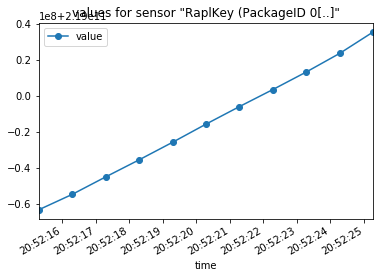

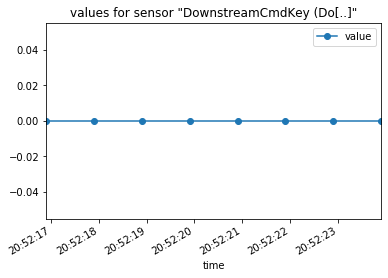

<IPython.core.display.Javascript object>

In [94]:
for sensorID,measurements in history.items():
    dataframe = pd.DataFrame(data=[(pd.Timestamp(t, unit='us'), m) 
                                   for t,m 
                                   in measurements])
    print("sensorID %s" % sensorID)
    dataframe.columns=["time","value"]
    dataframe = dataframe.set_index("time")
    print(dataframe)
    ax = dataframe.plot(marker='o', 
                        linestyle='-',
                        title='values for sensor "%s[..]"' % sensorID[:20])
    print("\n")